# Renaissance REMI+ Experiment: Embedding Visualization

### Imports

In [4]:
import sys
import os

if not os.path.exists("CounterpointTransformer"):
  !git clone https://github.com/iLykTurtlz/CounterpointTransformer.git


!pip install -e CounterpointTransformer

repo_path = os.path.abspath("CounterpointTransformer")
if repo_path not in sys.path:
    sys.path.append(repo_path)

Cloning into 'CounterpointTransformer'...
remote: Enumerating objects: 2927, done.
remote: Counting objects: 100% (2927/2927), done.
remote: Compressing objects: 100% (2337/2337), done.
remote: Total 2927 (delta 636), reused 2870 (delta 586), pack-reused 0 (from 0)
Receiving objects: 100% (2927/2927), 10.07 MiB | 21.61 MiB/s, done.
Resolving deltas: 100% (636/636), done.
Obtaining file:///content/CounterpointTransformer
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.3/29.3 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.0/159.0 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 78.8 MB/s eta 0:00:00
  Running setup.py develop for ren_counterpoint


In [5]:
# standard library imports
import torch
# import torch.nn as nn
import torch.nn.functional as F
# import math
# from pathlib import Path
# from torch.utils.data import DataLoader
# from typing import List
# import random
# from torch.optim import AdamW
# from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, OneCycleLR
# from tqdm.auto import tqdm
# import time
# import os
from google.colab import drive
# import mido
# from tqdm import tqdm
# import pickle
# from datetime import datetime
# import json
# from symusic import Score

from datasets import Dataset as HFDataset
from datasets import load_from_disk
# from pathlib import Path
# import multiprocessing
# from functools import partial
from tqdm.auto import tqdm

# from datasets import load_from_disk
# # from sklearn.model_selection import train_test_split
# from torch.utils.data import DataLoader

# from torch.utils.data import Dataset as TorchDataset # N.B. TorchDataset != Dataset
# import random


# from typing import Callable
# import re
# import glob

# from dataclasses import dataclass
# from typing import Optional, Dict, List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches

from sklearn.decomposition import PCA
# from mpl_toolkits.mplot3d import Axes3D
# from z3 import *

# import torch
from pathlib import Path
# import glob
import re
from typing import Dict, List



import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import pearsonr

from collections import Counter

import json

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import gdown
from datasets import load_from_disk

In [6]:
# renaissance counterpoint imports
from ren_counterpoint.tokenizer import RemiPlusTokenizer

### Load Tokenizer, Model, Training Log

In [18]:
def shared_link_to_id(shared_link: str) -> str:
    # This regex looks for the ID string after /d/ or /folders/
    match = re.search(r'/(?:d|folders)/([a-zA-Z0-9-_]+)', shared_link)
    if match:
        return match.group(1)
    return None

tokenizer_shared_link = 'https://drive.google.com/file/d/1XYZCv2ywEQe5wxK_aoaAPzcVAzN_xJVN/view?usp=sharing'
tokenizer_file_id = shared_link_to_id(tokenizer_shared_link)
tokenizer_download_link = f"https://drive.google.com/uc?id={tokenizer_file_id}"
tokenizer_save_path = '/content/tokenizer.json'

model_shared_link = 'https://drive.google.com/file/d/1ofQEm8sLr7CV6x4pgjMRTa_DF1CNru4c/view?usp=sharing'
model_file_id = shared_link_to_id(model_shared_link)
model_download_link = f"https://drive.google.com/uc?id={model_file_id}"
model_save_path = '/content/best_model.pt'

training_log_shared_link = 'https://drive.google.com/file/d/1vmleOUZo9h7kLxwhteXPMdCK2fbkPMDF/view?usp=sharing'
training_log_file_id = shared_link_to_id(training_log_shared_link)
training_log_download_link = f"https://drive.google.com/uc?id={training_log_file_id}"
training_log_save_path = '/content/training_log.json'

training_data_shared_link = 'https://drive.google.com/drive/folders/1lZpdFEjNVwR3kuTYqTWeWMljBYX_kNE9?usp=sharing'
training_data_file_id = shared_link_to_id(training_data_shared_link)
# training_data_download_link = f"https://drive.google.com/uc?id={training_data_file_id}"
training_data_save_path = '/content/training_data'


gdown.download(tokenizer_download_link, tokenizer_save_path, quiet=False)
gdown.download(model_download_link, model_save_path, quiet=False)
gdown.download(training_log_download_link, training_log_save_path, quiet=False)
gdown.download_folder(id=training_data_file_id, output=training_data_save_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1XYZCv2ywEQe5wxK_aoaAPzcVAzN_xJVN
To: /content/tokenizer.json
100%|██████████| 6.61k/6.61k [00:00<00:00, 2.80MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1ofQEm8sLr7CV6x4pgjMRTa_DF1CNru4c
From (redirected): https://drive.google.com/uc?id=1ofQEm8sLr7CV6x4pgjMRTa_DF1CNru4c&confirm=t&uuid=96b4f6ec-6ad8-493b-8ea8-5bd8906ebc9e
To: /content/best_model.pt
100%|██████████| 1.25G/1.25G [00:25<00:00, 49.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vmleOUZo9h7kLxwhteXPMdCK2fbkPMDF
To: /content/training_log.json
100%|██████████| 24.0k/24.0k [00:00<00:00, 30.8MB/s]
Retrieving folder contents


Processing file 1ZChM-UXfAwQEvZ-DmDGFjZzIMUz9kEhw cache-3b89317442a645f7.arrow
Processing file 1H-XmhnYShJsYWD2Taf5la-W-y5oI1JDH data-00000-of-00002.arrow
Processing file 1NeTrp7Ol3w1FHYowLv1lTJLVWvimPB-i data-00001-of-00002.arrow
Processing file 12gvwPHGfS3omx-tdQ2eh9YFpdDloMRbK dataset_info.json
Processing file 1CEryl6Z-5ng-iVOeL_rSfBik33f7gMV2 state.json


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1ZChM-UXfAwQEvZ-DmDGFjZzIMUz9kEhw
To: /content/training_data/cache-3b89317442a645f7.arrow
100%|██████████| 227k/227k [00:00<00:00, 9.72MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1H-XmhnYShJsYWD2Taf5la-W-y5oI1JDH
From (redirected): https://drive.google.com/uc?id=1H-XmhnYShJsYWD2Taf5la-W-y5oI1JDH&confirm=t&uuid=86657f43-e6f2-4b5c-9e3a-a49f9e59d6cc
To: /content/training_data/data-00000-of-00002.arrow
100%|██████████| 383M/383M [00:04<00:00, 80.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1NeTrp7Ol3w1FHYowLv1lTJLVWvimPB-i
From (redirected): https://drive.google.com/uc?id=1NeTrp7Ol3w1FHYowLv1lTJLVWvimPB-i&confirm=t&uuid=14102bc1-c801-4bc3-bc15-6b6dcef2598c
To: /content/training_data/data-00001-of-00002.arrow
100%|██████████| 394M/394M [00:03<00:00, 129MB/s]
Downloading...
From: https://

['/content/training_data/cache-3b89317442a645f7.arrow',
 '/content/training_data/data-00000-of-00002.arrow',
 '/content/training_data/data-00001-of-00002.arrow',
 '/content/training_data/dataset_info.json',
 '/content/training_data/state.json']

In [8]:
tokenizer = RemiPlusTokenizer(load_path=tokenizer_save_path)

/usr/local/lib/python3.12/dist-packages/miditok/tokenizations/remi.py:88: UserWarning: Attribute controls are not compatible with 'config.one_token_stream_for_programs' and multi-vocabulary tokenizers. Disabling them from the config.
  super().__init__(tokenizer_config, params)


In [9]:
# # To see the full vocab of size 680
# tokenizer.tokenizer.vocab

In [10]:
def load_model_params(model_path):
  return torch.load(model_path, map_location='cpu')

In [11]:
params = load_model_params(model_path=model_save_path)
embeddings = params['model_state_dict']['token_embedding.weight']
embeddings

tensor([[ 0.0689,  0.0735, -0.0627,  ..., -0.0457, -0.0098,  0.0565],
        [ 0.0458, -0.0450, -0.0392,  ..., -0.0048,  0.0097,  0.0264],
        [-0.0025,  0.0448,  0.0523,  ...,  0.0188, -0.0407,  0.0086],
        ...,
        [ 0.0344, -0.0218,  0.0472,  ..., -0.0500,  0.0171,  0.0386],
        [ 0.0382,  0.0129, -0.0319,  ...,  0.0247, -0.0275,  0.0265],
        [-0.0240,  0.0632,  0.0548,  ...,  0.0049, -0.0135,  0.0023]])

In [12]:
log_data = None
with open(training_log_save_path, 'r') as f:
  log_data = json.load(f)

### Training loss

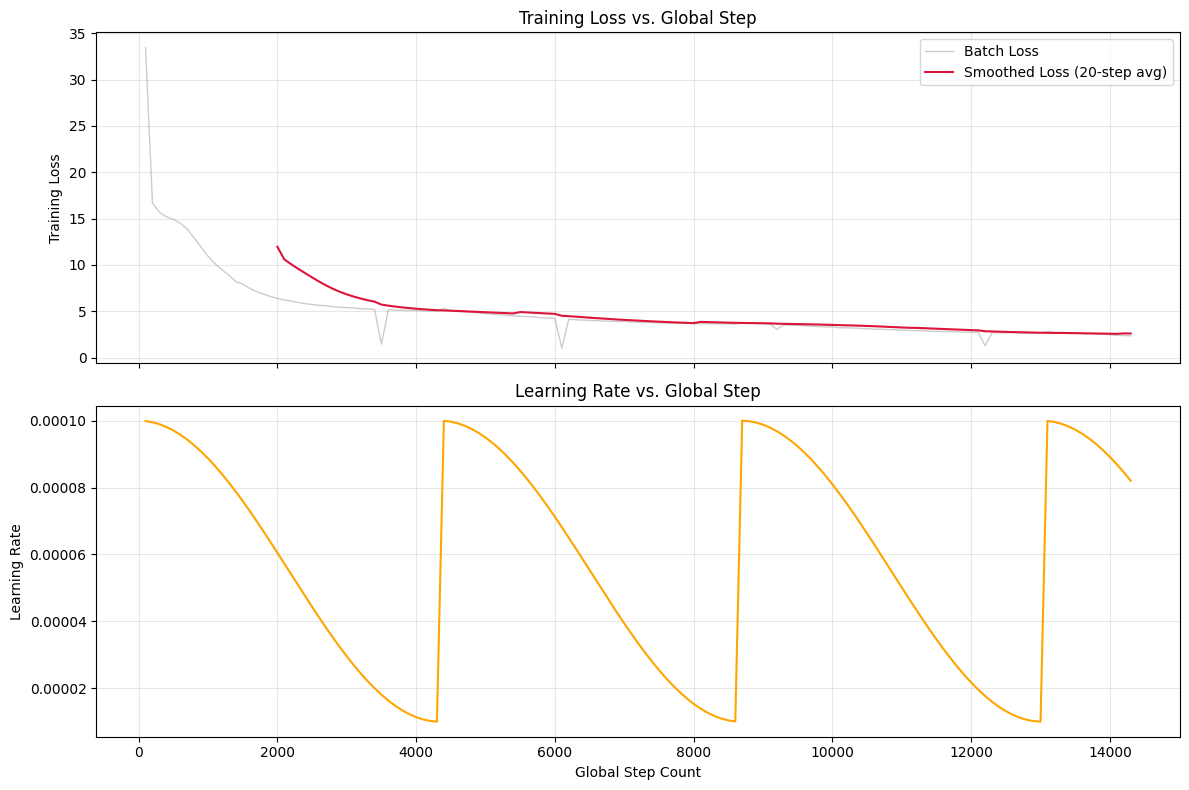

In [13]:
# Global train step metrics
df_epochs = pd.DataFrame(log_data['epochs'])
df_steps = pd.DataFrame(log_data['steps'])


fig_steps, (ax_loss_step, ax_lr_step) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)


ax_loss_step.plot(df_steps['step'], df_steps['train_loss'],
                  label='Batch Loss', color='gray', alpha=0.4, linewidth=1)
# Rolling average
ax_loss_step.plot(df_steps['step'], df_steps['train_loss'].rolling(window=20).mean(),
                  label='Smoothed Loss (20-step avg)', color='crimson', linewidth=1.5)
ax_loss_step.set_ylabel('Training Loss')
ax_loss_step.set_title('Training Loss vs. Global Step')
ax_loss_step.legend(loc='upper right')
ax_loss_step.grid(True, alpha=0.3)


ax_lr_step.plot(df_steps['step'], df_steps['lr'],
                label='Learning Rate', color='orange', linewidth=1.5)
ax_lr_step.set_ylabel('Learning Rate')
ax_lr_step.set_xlabel('Global Step Count')
ax_lr_step.set_title('Learning Rate vs. Global Step')
ax_lr_step.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()




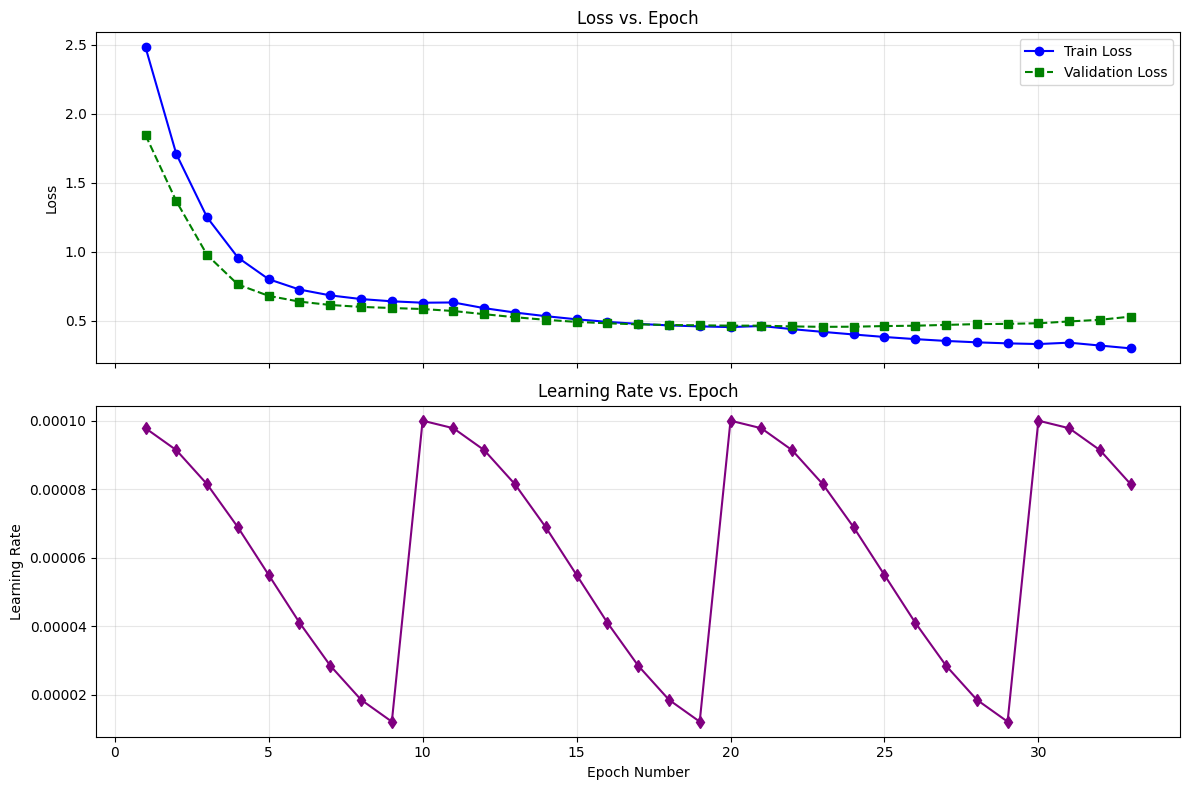

In [14]:
# Per epoch metrics
fig_epochs, (ax_loss_epoch, ax_lr_epoch) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Graph A: Loss vs Epochs
ax_loss_epoch.plot(df_epochs['epoch'], df_epochs['train_loss'],
                   label='Train Loss', marker='o', linestyle='-', color='blue')
ax_loss_epoch.plot(df_epochs['epoch'], df_epochs['val_loss'],
                   label='Validation Loss', marker='s', linestyle='--', color='green')
ax_loss_epoch.set_ylabel('Loss')
ax_loss_epoch.set_title('Loss vs. Epoch')
ax_loss_epoch.legend(loc='upper right')
ax_loss_epoch.grid(True, alpha=0.3)

# Graph B: Learning Rate vs Epochs
# Note: This usually shows the LR at the *end* of the epoch
ax_lr_epoch.plot(df_epochs['epoch'], df_epochs['lr'],
                 label='Learning Rate (End of Epoch)', marker='d', color='purple', linestyle='-')
ax_lr_epoch.set_ylabel('Learning Rate')
ax_lr_epoch.set_xlabel('Epoch Number')
ax_lr_epoch.set_title('Learning Rate vs. Epoch')
ax_lr_epoch.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [15]:
embeddings.shape

torch.Size([680, 1024])

In [19]:
train_dataset = load_from_disk(training_data_save_path)

In [20]:
train_dataset[0].keys()

dict_keys(['filename', 'token_ids', 'length'])

In [21]:
# Q: what range of pitches is represented by the training data?
def get_dataset_pitch_info(dataset: HFDataset, tokenizer):
  inv_map = {v:k for k,v in tokenizer.tokenizer.vocab.items()}

  freqs = Counter( int(inv_map[id].replace('Pitch_', ''))
                   for example in tqdm(train_dataset)
                   for id in example['token_ids']
                     if inv_map[id].startswith('Pitch_') )
  min_pitch = min(freqs.keys())
  max_pitch = max(freqs.keys())
  holes = set(range(min_pitch, max_pitch+1)) - freqs.keys()
  return {'freqs' : freqs,
          'min_pitch': min_pitch,
          'max_pitch': max_pitch,
          'holes': sorted(holes)}

pitch_data = get_dataset_pitch_info(train_dataset, tokenizer)
pitch_data

  0%|          | 0/27804 [00:00<?, ?it/s]

{'freqs': Counter({50: 582040,
          53: 774743,
          47: 329499,
          52: 728705,
          48: 431458,
          57: 1081666,
          55: 965743,
          60: 1189683,
          59: 1162623,
          45: 245310,
          49: 437384,
          62: 1194854,
          65: 1131374,
          64: 1159106,
          61: 1200770,
          67: 987493,
          43: 149365,
          36: 9039,
          38: 29719,
          41: 74914,
          40: 57726,
          58: 1082442,
          46: 252087,
          54: 844529,
          56: 974490,
          51: 585182,
          63: 1196157,
          66: 1099777,
          68: 981401,
          44: 150072,
          37: 9100,
          39: 29890,
          42: 84761,
          69: 824410,
          70: 817738,
          71: 678995,
          72: 553387,
          73: 536617,
          74: 380209,
          75: 375593,
          76: 241301,
          77: 205785,
          78: 157749,
          79: 83952,
          80: 80577,
  

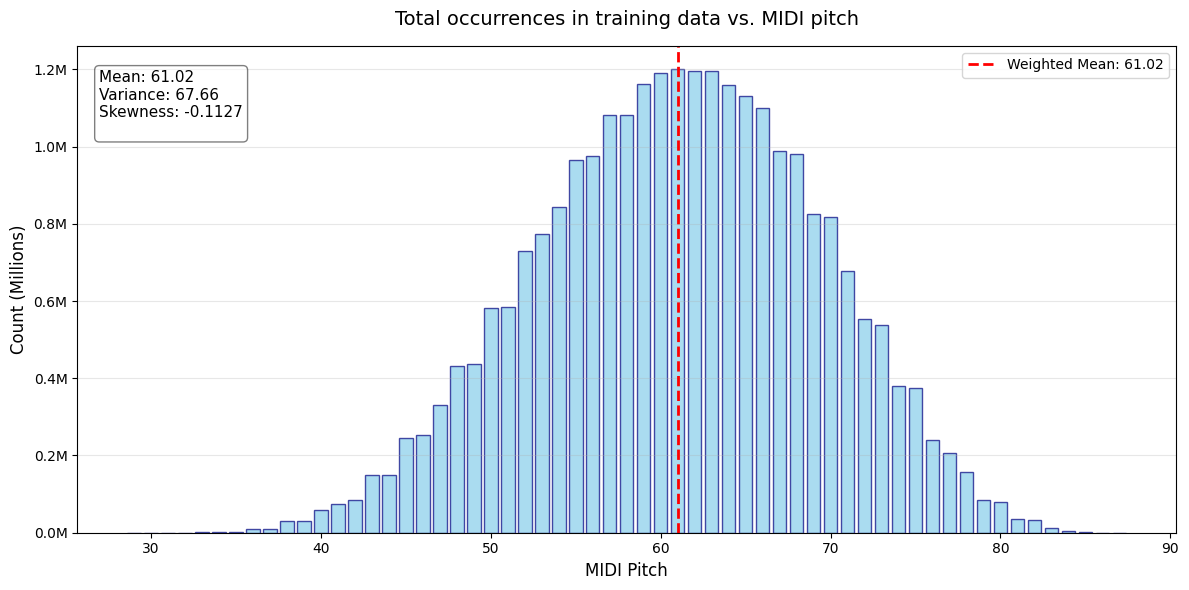

In [22]:
pitch_freqs = sorted(pitch_data['freqs'].items())
x_pitches = [f[0] for f in pitch_freqs]
y_counts = [f[1] for f in pitch_freqs]
total_count = sum(y_counts)
weighted_mean = sum(p * c for p, c in zip(x_pitches, y_counts)) / total_count
weighted_variance = sum(c * ((p - weighted_mean) ** 2) for p, c in zip(x_pitches, y_counts)) / total_count
weighted_std = np.sqrt(weighted_variance)
numerator = sum(c * ((p - weighted_mean) ** 3) for p, c in zip(x_pitches, y_counts)) / total_count
skewness = numerator / (weighted_std ** 3)


fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(x_pitches, y_counts, width=0.8, color='skyblue', edgecolor='navy', alpha=0.7)

# Title and Labels
ax.set_title("Total occurrences in training data vs. MIDI pitch", fontsize=14, pad=15)
ax.set_xlabel("MIDI Pitch", fontsize=12)
ax.set_ylabel("Count (Millions)", fontsize=12)

# This function formats 1,000,000 as "1.0" or "1.2"
def millions_formatter(x, pos):
    return f'{x*1e-6:.1f}M'

ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))

# Vertical Line for Weighted Mean
ax.axvline(weighted_mean, color='red', linestyle='--', linewidth=2, label=f'Weighted Mean: {weighted_mean:.2f}')

# Display Stats on Plot
stats_text = (f"Mean: {weighted_mean:.2f}\n"
              f"Variance: {weighted_variance:.2f}\n"
              f"Skewness: {skewness:.4f}\n")
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.02, 0.95, stats_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

ax.legend(loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

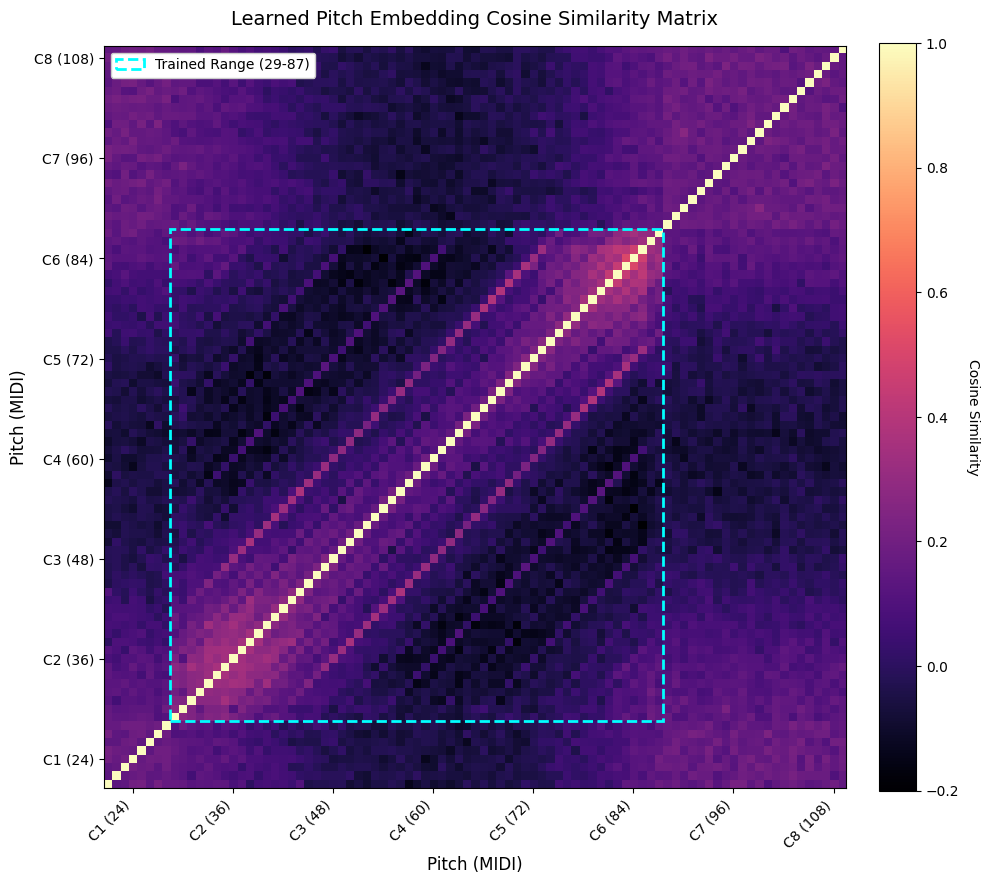

In [26]:
# heatmap
inv_vocab = {v:k for k,v in tokenizer.tokenizer.vocab.items()}
pitch_vecs = {int(inv_vocab[i].replace('Pitch_', '')):vec for i,vec in enumerate(embeddings) if inv_vocab[i].startswith('Pitch_')}
pitches = sorted(pitch_vecs.keys())
sorted_vecs = torch.stack([pitch_vecs[p] for p in pitches])

vecs_norm = F.normalize(sorted_vecs, p=2, dim=1)
sim_matrix = torch.mm(vecs_norm, vecs_norm.t()).detach().cpu().numpy()

idx_start = pitches.index(pitch_data['min_pitch'])
idx_end = pitches.index(pitch_data['max_pitch'])

fig, ax = plt.subplots(figsize=(10,10))

im = ax.imshow(sim_matrix, origin='lower', cmap='magma', vmin=-0.2, vmax=1.0)

rect = patches.Rectangle(
    (idx_start - 0.5, idx_start - 0.5),    # (x, y) bottom-left
    (idx_end - idx_start + 1),             # width
    (idx_end - idx_start + 1),             # height
    linewidth=2, edgecolor='cyan', facecolor='none', linestyle='--',
    label=f'Trained Range ({pitch_data['min_pitch']}-{pitch_data['max_pitch']})'
)
ax.add_patch(rect)

tick_step = 12
# Find a 'C' close to the start to align ticks nicely (e.g., C2 = 36)
first_c_idx = next(i for i, p in enumerate(pitches) if p % 12 == 0)
tick_indices = range(first_c_idx, len(pitches), tick_step)
tick_labels = [f"C{pitches[i]//12 - 1} ({pitches[i]})" for i in tick_indices]

ax.set_xticks(tick_indices)
ax.set_xticklabels(tick_labels, rotation=45, ha='right')
ax.set_yticks(tick_indices)
ax.set_yticklabels(tick_labels)

ax.set_title("Learned Pitch Embedding Cosine Similarity Matrix", fontsize=14, pad=15)
ax.set_xlabel("Pitch (MIDI)", fontsize=12)
ax.set_ylabel("Pitch (MIDI)", fontsize=12)

# Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Cosine Similarity", rotation=270, labelpad=15)

# Legend for the box (create a dummy plot to hold the label)
ax.legend(handles=[rect], loc='upper left', framealpha=1.0)

plt.tight_layout()
plt.show()

In [27]:
def midi_gamut(vocab: Dict[str, int]) -> List[int]:
  """Get all MIDI pitches in the vocab"""
  pitches = sorted( int( k.replace('Pitch_', '') ) for k in vocab.keys()
                                                   if k.startswith('Pitch_') )
  return pitches

def get_octave(midi_note: int) -> str:
  """Octave number, e.g. 4 for C4, middle C"""
  return midi_note // 12 - 1

def get_pitch_class_name(midi_note: int) -> str:
  """Note name for a midi pitch"""
  notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
  return notes[midi_note % 12]

def midi_to_notename(midi_note: int) -> str:
  """Combine pitch class with octave, e.g. 'C4' for middle C"""
  return get_pitch_class_name(midi_note) + str(get_octave(midi_note))

### PCA with dim=4

In [38]:
vocab = tokenizer.tokenizer.vocab
all_pitches = midi_gamut(vocab) # midi_nums

# limit to pitches seen in training data
min_p, max_p = pitch_data['min_pitch'], pitch_data['max_pitch']
pitches = [p for p in all_pitches if min_p <= p <= max_p]

min_midi = pitches[0]
max_midi = pitches[-1]

first_pitch_token = f"Pitch_{pitches[0]}"
start_idx = vocab[first_pitch_token]
pitch_indices = [vocab[f"Pitch_{p}"] for p in pitches]
pitch_vecs = embeddings[pitch_indices].float().numpy()

pca4 = PCA(n_components=4, svd_solver='full')
proj4 = pca4.fit_transform(pitch_vecs)

# Hold onto a data frame
pca4df = pd.DataFrame({
    'midi': pitches,
    'note': [midi_to_notename(m) for m in pitches],
    'pitch_class': [m % 12 for m in pitches], # 0=C, 1=C#, etc.
    'pitch_class_name': [get_pitch_class_name(m) for m in pitches]
})

pca4df['PC1'] = proj4[:, 0]
pca4df['PC2'] = proj4[:, 1]
pca4df['PC3'] = proj4[:, 2]
pca4df['PC4'] = proj4[:, 3]


print("Test: which PC correlates most with pitch height?")
corrs4 = [pearsonr(pca4df['midi'], pca4df[col])[0] for col in ('PC1', 'PC2', 'PC3', 'PC4')]
print(f"Correlation with Pitch Height (MIDI):")
print(f"  PC1: {corrs4[0]:.4f}")
print(f"  PC2: {corrs4[1]:.4f}")
print(f"  PC3: {corrs4[2]:.4f}")
print(f"  PC4: {corrs4[2]:.4f}")

Test: which PC correlates most with pitch height?
Correlation with Pitch Height (MIDI):
  PC1: 0.9432
  PC2: -0.0199
  PC3: 0.2010
  PC4: 0.2010


In [39]:
pca4df.columns

Index(['midi', 'note', 'pitch_class', 'pitch_class_name', 'PC1', 'PC2', 'PC3',
       'PC4'],
      dtype='object')

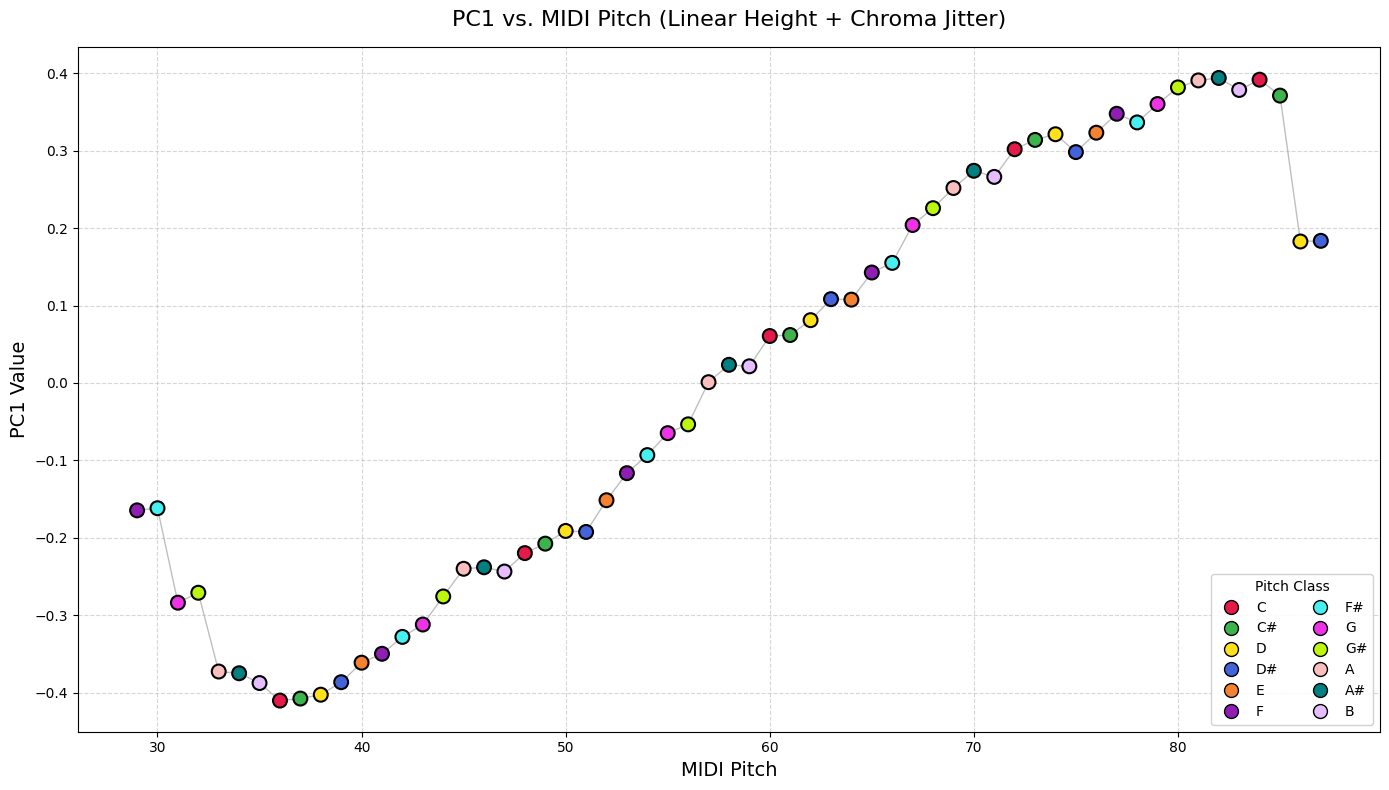

In [40]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# 1. Sort the dataframe to ensure the line trace connects points in order
pca4df = pca4df.sort_values('midi')

# 2. Define 12 Distinct High-Contrast Colors
# We avoid shades of green/blue that look alike.
# Using a mix of primary/secondary colors and distinct dark/light shades.
distinct_colors = [
    '#E6194B', # Red
    '#3CB44B', # Green
    '#FFE119', # Yellow
    '#4363D8', # Blue
    '#F58231', # Orange
    '#911EB4', # Purple
    '#46F0F0', # Cyan
    '#F032E6', # Magenta
    '#BCF60C', # Lime
    '#FABEBE', # Pink
    '#008080', # Teal
    '#E6BEFF'  # Lavender
]

# Map pitch class (0-11) to these colors
color_map = {i: distinct_colors[i] for i in range(12)}
point_colors = [color_map[pc] for pc in pca4df['pitch_class']]

# 3. Plot
plt.figure(figsize=(14, 8))

# A. The Trace Line (Connects dots sequentially)
plt.plot(pca4df['midi'], pca4df['PC1'], color='gray', linestyle='-', linewidth=1, alpha=0.5, zorder=1)

# B. The Scatter Points
scatter = plt.scatter(
    pca4df['midi'],
    pca4df['PC1'],
    c=point_colors,
    s=100,
    alpha=1.0,
    edgecolors='black',
    linewidth=1.5,
    zorder=2
)

# 4. Formatting
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('PC1 vs. MIDI Pitch (Linear Height + Chroma Jitter)', fontsize=16, pad=15)
plt.xlabel('MIDI Pitch', fontsize=14)
plt.ylabel('PC1 Value', fontsize=14)

# 5. Manual Legend
pitch_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
legend_handles = []
for i in range(12):
    handle = plt.Line2D([0], [0], marker='o', color='w',
                        label=pitch_names[i],
                        markerfacecolor=distinct_colors[i],
                        markersize=10,
                        markeredgecolor='black')
    legend_handles.append(handle)

plt.legend(handles=legend_handles, title="Pitch Class", loc='lower right', ncol=2, framealpha=0.9)

plt.tight_layout()
plt.savefig('pc1_vs_midi_contrast.png')
plt.show()

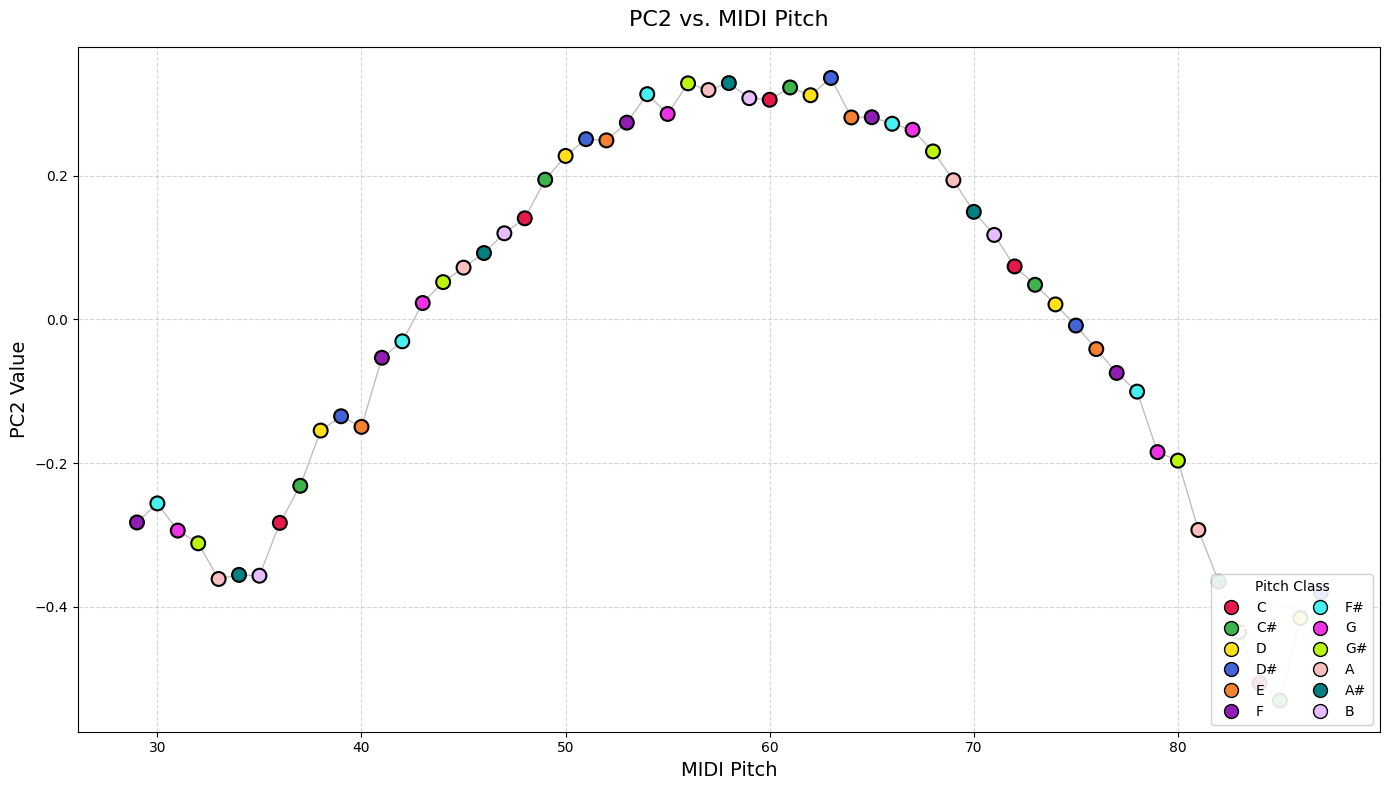

In [45]:


# 1. Sort the dataframe to ensure the line trace connects points in order
pca4df = pca4df.sort_values('midi')

# 2. Define 12 Distinct High-Contrast Colors
# We avoid shades of green/blue that look alike.
# Using a mix of primary/secondary colors and distinct dark/light shades.
distinct_colors = [
    '#E6194B', # Red
    '#3CB44B', # Green
    '#FFE119', # Yellow
    '#4363D8', # Blue
    '#F58231', # Orange
    '#911EB4', # Purple
    '#46F0F0', # Cyan
    '#F032E6', # Magenta
    '#BCF60C', # Lime
    '#FABEBE', # Pink
    '#008080', # Teal
    '#E6BEFF'  # Lavender
]

# Map pitch class (0-11) to these colors
color_map = {i: distinct_colors[i] for i in range(12)}
point_colors = [color_map[pc] for pc in pca4df['pitch_class']]

# 3. Plot
plt.figure(figsize=(14, 8))

# A. The Trace Line (Connects dots sequentially)
plt.plot(pca4df['midi'], pca4df['PC2'], color='gray', linestyle='-', linewidth=1, alpha=0.5, zorder=1)

# B. The Scatter Points
scatter = plt.scatter(
    pca4df['midi'],
    pca4df['PC2'],
    c=point_colors,
    s=100,
    alpha=1.0,
    edgecolors='black',
    linewidth=1.5,
    zorder=2
)

# 4. Formatting
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('PC2 vs. MIDI Pitch', fontsize=16, pad=15)
plt.xlabel('MIDI Pitch', fontsize=14)
plt.ylabel('PC2 Value', fontsize=14)

# 5. Manual Legend
pitch_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
legend_handles = []
for i in range(12):
    handle = plt.Line2D([0], [0], marker='o', color='w',
                        label=pitch_names[i],
                        markerfacecolor=distinct_colors[i],
                        markersize=10,
                        markeredgecolor='black')
    legend_handles.append(handle)

plt.legend(handles=legend_handles, title="Pitch Class", loc='lower right', ncol=2, framealpha=0.9)

plt.tight_layout()
plt.savefig('pc1_vs_midi_contrast.png')
plt.show()

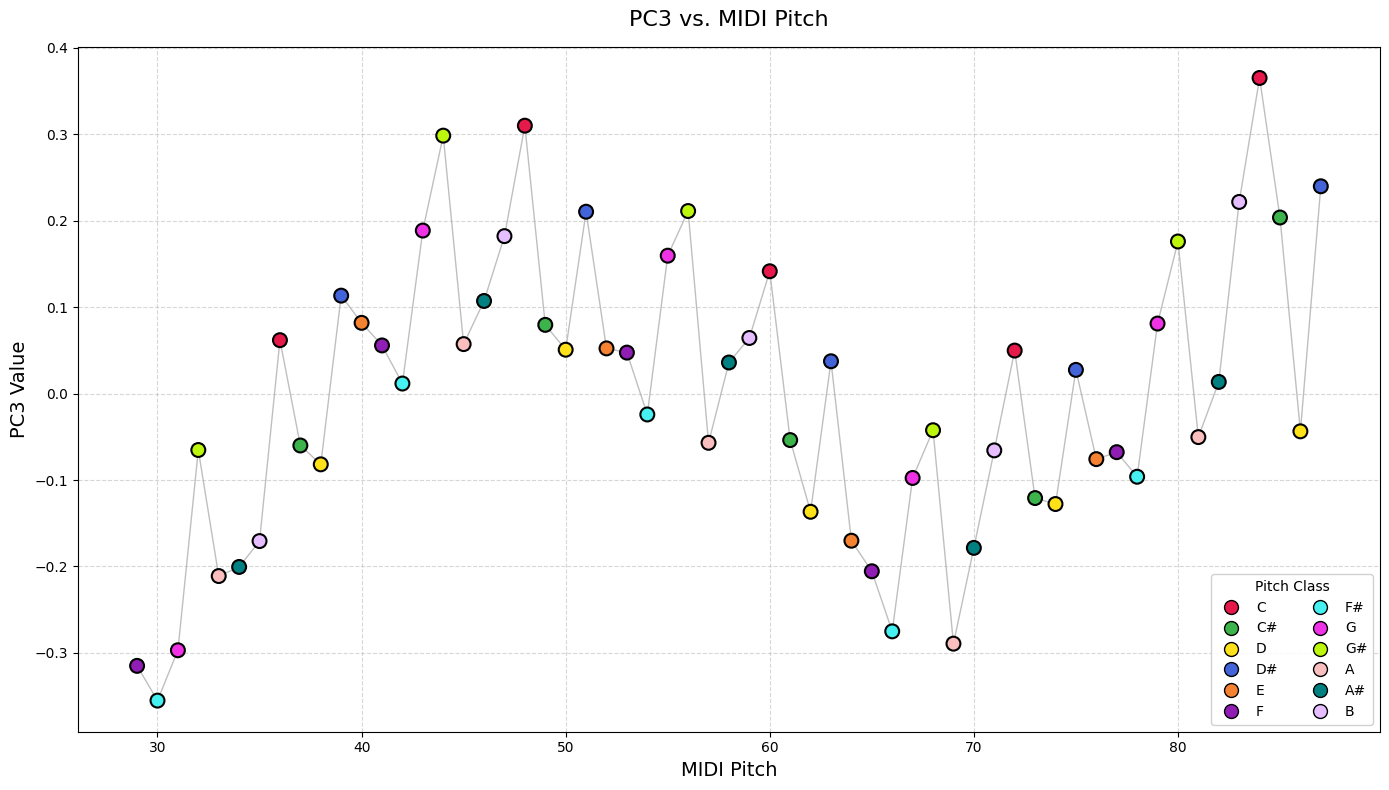

In [46]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# 1. Sort the dataframe to ensure the line trace connects points in order
pca4df = pca4df.sort_values('midi')

# 2. Define 12 Distinct High-Contrast Colors
# We avoid shades of green/blue that look alike.
# Using a mix of primary/secondary colors and distinct dark/light shades.
distinct_colors = [
    '#E6194B', # Red
    '#3CB44B', # Green
    '#FFE119', # Yellow
    '#4363D8', # Blue
    '#F58231', # Orange
    '#911EB4', # Purple
    '#46F0F0', # Cyan
    '#F032E6', # Magenta
    '#BCF60C', # Lime
    '#FABEBE', # Pink
    '#008080', # Teal
    '#E6BEFF'  # Lavender
]

# Map pitch class (0-11) to these colors
color_map = {i: distinct_colors[i] for i in range(12)}
point_colors = [color_map[pc] for pc in pca4df['pitch_class']]

# 3. Plot
plt.figure(figsize=(14, 8))

# A. The Trace Line (Connects dots sequentially)
plt.plot(pca4df['midi'], pca4df['PC3'], color='gray', linestyle='-', linewidth=1, alpha=0.5, zorder=1)

# B. The Scatter Points
scatter = plt.scatter(
    pca4df['midi'],
    pca4df['PC3'],
    c=point_colors,
    s=100,
    alpha=1.0,
    edgecolors='black',
    linewidth=1.5,
    zorder=2
)

# 4. Formatting
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('PC3 vs. MIDI Pitch', fontsize=16, pad=15)
plt.xlabel('MIDI Pitch', fontsize=14)
plt.ylabel('PC3 Value', fontsize=14)

# 5. Manual Legend
pitch_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
legend_handles = []
for i in range(12):
    handle = plt.Line2D([0], [0], marker='o', color='w',
                        label=pitch_names[i],
                        markerfacecolor=distinct_colors[i],
                        markersize=10,
                        markeredgecolor='black')
    legend_handles.append(handle)

plt.legend(handles=legend_handles, title="Pitch Class", loc='lower right', ncol=2, framealpha=0.9)

plt.tight_layout()
plt.savefig('pc1_vs_midi_contrast.png')
plt.show()

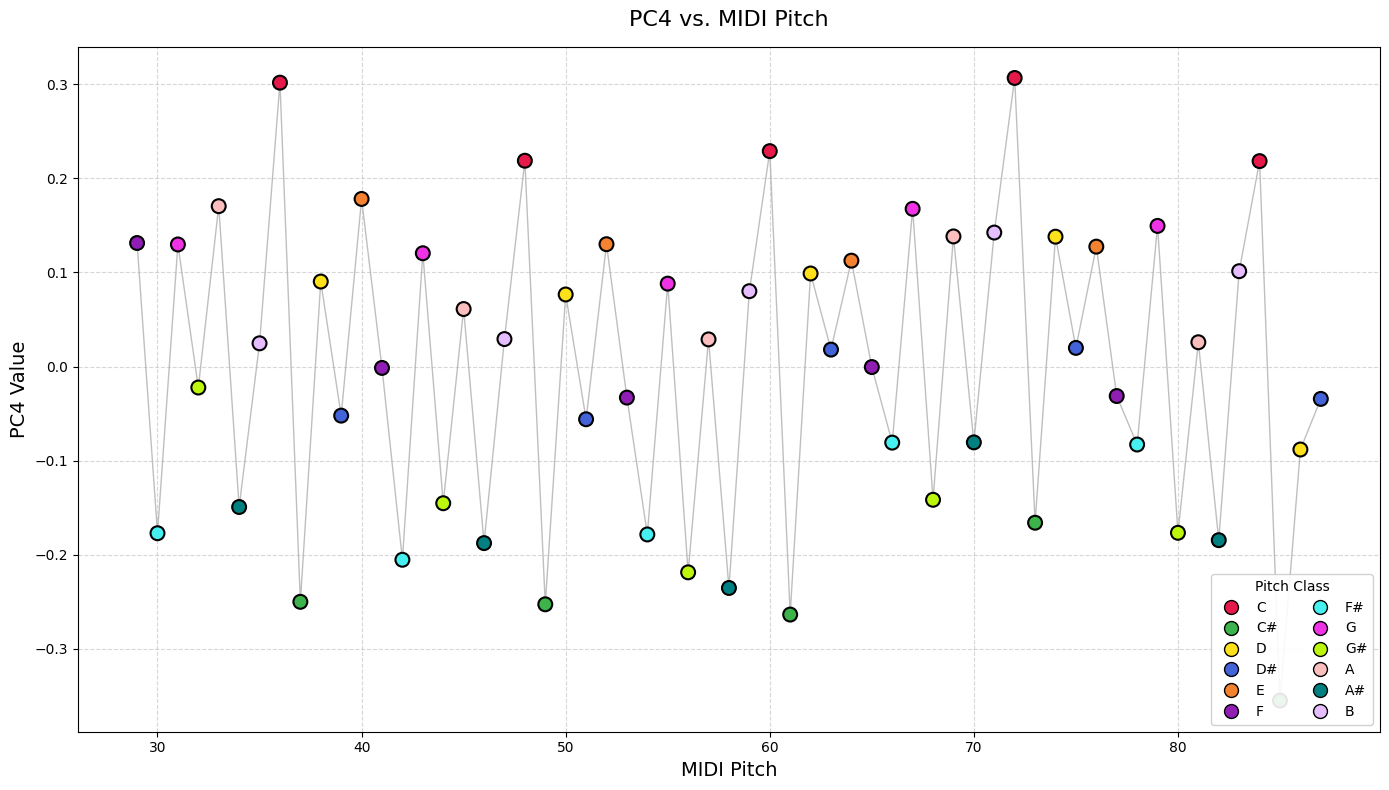

In [47]:
# Sort the dataframe to ensure the line trace connects points in order
pca4df = pca4df.sort_values('midi')

# 12 high contrast colors (the most similar are a tritone, or six pitches, apart)
distinct_colors = [
    '#E6194B', # Red
    '#3CB44B', # Green
    '#FFE119', # Yellow
    '#4363D8', # Blue
    '#F58231', # Orange
    '#911EB4', # Purple
    '#46F0F0', # Cyan
    '#F032E6', # Magenta
    '#BCF60C', # Lime
    '#FABEBE', # Pink
    '#008080', # Teal
    '#E6BEFF'  # Lavender
]

# Map pitch class (0-11) to these colors
color_map = {i: distinct_colors[i] for i in range(12)}
point_colors = [color_map[pc] for pc in pca4df['pitch_class']]

# 3. Plot
plt.figure(figsize=(14, 8))

# A. The Trace Line (Connects dots sequentially)
plt.plot(pca4df['midi'], pca4df['PC4'], color='gray', linestyle='-', linewidth=1, alpha=0.5, zorder=1)

# B. The Scatter Points
scatter = plt.scatter(
    pca4df['midi'],
    pca4df['PC4'],
    c=point_colors,
    s=100,
    alpha=1.0,
    edgecolors='black',
    linewidth=1.5,
    zorder=2
)

# 4. Formatting
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('PC4 vs. MIDI Pitch', fontsize=16, pad=15)
plt.xlabel('MIDI Pitch', fontsize=14)
plt.ylabel('PC4 Value', fontsize=14)

# 5. Manual Legend
pitch_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
legend_handles = []
for i in range(12):
    handle = plt.Line2D([0], [0], marker='o', color='w',
                        label=pitch_names[i],
                        markerfacecolor=distinct_colors[i],
                        markersize=10,
                        markeredgecolor='black')
    legend_handles.append(handle)

plt.legend(handles=legend_handles, title="Pitch Class", loc='lower right', ncol=2, framealpha=0.9)

plt.tight_layout()
plt.savefig('pc1_vs_midi_contrast.png')
plt.show()

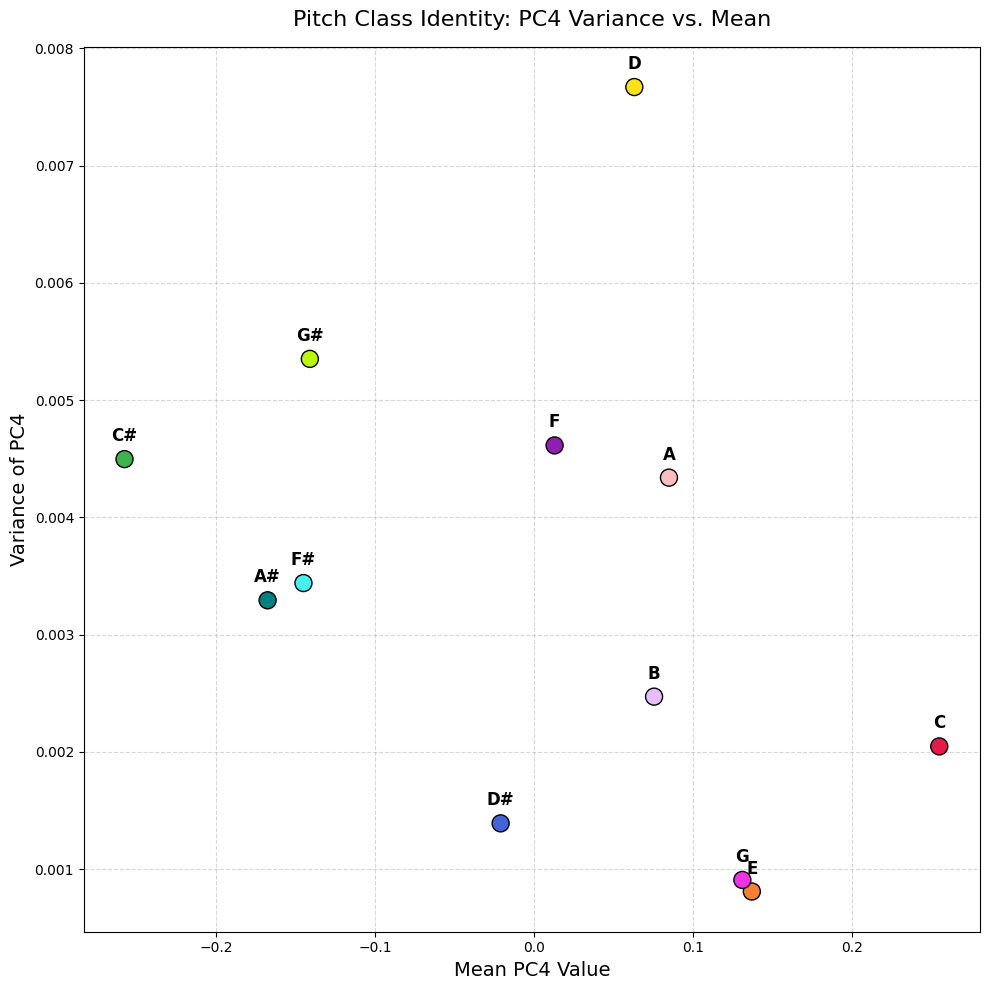

In [82]:
# Let's look for consistency in the pitch classes.
# Group by pitch class and calculate stats for PC4
pc4_stats = pca4df.groupby('pitch_class')['PC4'].agg(['mean', 'var']).reset_index()

distinct_colors = [
    '#E6194B', # Red
    '#3CB44B', # Green
    '#FFE119', # Yellow
    '#4363D8', # Blue
    '#F58231', # Orange
    '#911EB4', # Purple
    '#46F0F0', # Cyan
    '#F032E6', # Magenta
    '#BCF60C', # Lime
    '#FABEBE', # Pink
    '#008080', # Teal
    '#E6BEFF'  # Lavender
]

pitch_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

plt.figure(figsize=(10, 10))

plt.scatter(
    pc4_stats['mean'],
    pc4_stats['var'],
    c=distinct_colors,
    s=150,
    alpha=1.0,
    edgecolors='black',
    linewidth=1.0,
    zorder=2
)

for i in range(len(pc4_stats)):
    x = pc4_stats.iloc[i]['mean']
    y = pc4_stats.iloc[i]['var']
    label = pitch_names[int(pc4_stats.iloc[i]['pitch_class'])]

    # Add text slightly offset from the dot
    plt.text(x, y + (pc4_stats['var'].max() * 0.02), label,
             fontsize=12, fontweight='bold', ha='center', zorder=3)

plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Pitch Class Identity: PC4 Variance vs. Mean', fontsize=16, pad=15)
plt.xlabel('Mean PC4 Value', fontsize=14)
plt.ylabel('Variance of PC4', fontsize=14)


plt.tight_layout()
plt.savefig('pc4_mean_vs_variance.png')
plt.show()



### Interval consistency

In [55]:
vocab = tokenizer.tokenizer.vocab
all_pitches = sorted(int(tok_name.replace('Pitch_','')) for tok_name in vocab if tok_name.startswith('Pitch_'))
pitch_embeddings = {i:embeddings[vocab[f"Pitch_{i}"]] for i in all_pitches}

In [58]:
def get_interval_consistency(semitones, pitch_vecs, subtract_mean=False):
    """
    Calculates how consistent the vector direction is for a specific interval
    across the entire pitch range.

    Args:
        semitones (int): The interval size (e.g., 7 for a Perfect 5th).
        pitch_vecs (dict): Dictionary {midi_pitch (int): embedding_vector (Tensor)}.

    Returns:
        float: Average cosine similarity (1.0 = Perfect Translation, 0.0 = Orthogonal/Random).
    """
    interval_vectors = []

    # Sort keys just to be deterministic, though set lookup is O(1)
    pitches = sorted(pitch_vecs.keys())

    for p in pitches:
      target_p = p + semitones

      # Check if the interval target exists in our valid vocabulary
      if target_p in pitch_vecs:
        # Vector arithmetic: Target (p+k) - Source (p)
        diff_vector = pitch_vecs[target_p] - pitch_vecs[p]
        interval_vectors.append(diff_vector)

    if not interval_vectors:
        return 0.0

    # Stack into a single tensor: Shape [num_pairs, d_model]
    vectors_tensor = torch.stack(interval_vectors)

    if subtract_mean:
      mean_vec = vectors_tensor.mean(dim=0, keepdim=True)
      vectors_centered = vectors_tensor - mean_vec
      vectors_tensor = vectors_centered

    # Normalize vectors to unit length for Cosine Similarity
    vectors_norm = F.normalize(vectors_tensor, p=2, dim=1)

    # Compute Similarity Matrix (All pairs vs All pairs) via Matrix Mult
    similarity_matrix = torch.mm(vectors_norm, vectors_norm.t())

    # Calculate average similarity, excluding the main diagonal (self-similarity)
    n = similarity_matrix.shape[0]
    if n > 1:
      # Sum of matrix - Sum of diagonal (which is always n*1.0)
      sum_off_diag = torch.sum(similarity_matrix) - n
      count_off_diag = n * (n - 1)
      avg_sim = sum_off_diag / count_off_diag
      return avg_sim.item()

    return 0.0

In [59]:
print("\n--- Interval Consistency Scores (Cosine Sim) Part 1 ---")
print("Do interval vectors point in the same direction across the register?")
print("(1.0 = Perfect Equivalence, 0.0 = Orthogonal/Random)")

intervals = {
  1: "Minor 2nd",
  2: "Major 2nd",
  3: "Minor 3rd",
  4: "Major 3rd",
  5: "Perfect 4th",
  6: "Tritone",
  7: "Perfect 5th",
  8: "Minor 6th",
  9: "Major 6th",
  10: "Minor 7th",
  11: "Major 7th",
  12: "Octave"
}



filtered_vecs = {k:v for k,v in pitch_embeddings.items()
                     if pitch_data['min_pitch'] <= k <= pitch_data['max_pitch']}


for semitones, name in intervals.items():
  score = get_interval_consistency(semitones, filtered_vecs)
  print(f"{name:12s} (+{semitones}): {score:.4f}")


--- Interval Consistency Scores (Cosine Sim) Part 1 ---
Do interval vectors point in the same direction across the register?
(1.0 = Perfect Equivalence, 0.0 = Orthogonal/Random)
Minor 2nd    (+1): -0.0171
Major 2nd    (+2): -0.0169
Minor 3rd    (+3): -0.0163
Major 3rd    (+4): -0.0154
Perfect 4th  (+5): -0.0139
Tritone      (+6): -0.0130
Perfect 5th  (+7): -0.0103
Minor 6th    (+8): -0.0084
Major 6th    (+9): -0.0056
Minor 7th    (+10): -0.0033
Major 7th    (+11): 0.0009
Octave       (+12): 0.0140


In [60]:
print("\n--- Interval Consistency Scores (Cosine Sim) Part 2 ---")
print("If we subtract away the mean for each interval, do the residuals yield a consistent relationship?")
print("(1.0 = Perfect Equivalence, 0.0 = Orthogonal/Random)")

intervals = {
  1: "Minor 2nd",
  2: "Major 2nd",
  3: "Minor 3rd",
  4: "Major 3rd",
  5: "Perfect 4th",
  6: "Tritone",
  7: "Perfect 5th",
  8: "Minor 6th",
  9: "Major 6th",
  10: "Minor 7th",
  11: "Major 7th",
  12: "Octave"
}

filtered_vecs = {k:v for k,v in pitch_embeddings.items()
                     if pitch_data['min_pitch'] <= k <= pitch_data['max_pitch']}
# filtered_vecs = {k:v for k,v in pitch_vecs.items()
#                      if 50 <= k <= 70}

for semitones, name in intervals.items():
  score = get_interval_consistency(semitones, filtered_vecs, subtract_mean=True)
  print(f"{name:12s} (+{semitones}): {score:.4f}")


--- Interval Consistency Scores (Cosine Sim) Part 2 ---
If we subtract away the mean for each interval, do the residuals yield a consistent relationship?
(1.0 = Perfect Equivalence, 0.0 = Orthogonal/Random)
Minor 2nd    (+1): -0.0175
Major 2nd    (+2): -0.0178
Minor 3rd    (+3): -0.0181
Major 3rd    (+4): -0.0185
Perfect 4th  (+5): -0.0188
Tritone      (+6): -0.0192
Perfect 5th  (+7): -0.0195
Minor 6th    (+8): -0.0199
Major 6th    (+9): -0.0203
Minor 7th    (+10): -0.0207
Major 7th    (+11): -0.0212
Octave       (+12): -0.0212
